In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sys

from collections import defaultdict

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder

sys.path.insert(0, '../python/')
from helpers import *

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})
warnings.filterwarnings('ignore')

# Feature Importance

In [2]:
# features
# - hotel: [Resort Hotel, City Hotel] => [0, 1]
# - total_nights: [1, 2, 3, 4, 5, 6, 7, 8] => dummies
# - total_special_requests: [0, 1, 2] => dummies
# - market_segment: [Corporate, Online TA, Offline TA/TO, Direct, Groups] => dummies
# - room_difference: [0, 1]
# - party_size: [1, 2, 3] => dummies
# - booking_changes: [0, 1]

In [3]:
data = pd.read_csv('../../data/train/cancellations.csv')

feats = ['hotel','market_segment', 'total_of_special_requests', 
         'total_nights', 'room_difference', 'party_size', 'booking_changes']
dummy_cols = ['total_nights', 'total_of_special_requests', 'market_segment', 'party_size']

X = data[feats].copy()

X.replace(['Resort Hotel', 'City Hotel'], [0, 1], inplace=True)
X.loc[np.argwhere((X['total_nights'] >= 8).values).flatten(), 'total_nights'] = 8
X.loc[np.argwhere((X['total_of_special_requests'] >= 2).values).flatten(), 'total_of_special_requests'] = 2
X.loc[np.argwhere(X['market_segment'].isin(['Aviation', 'Complementary']).values).flatten(), 'market_segment'] = 'Corporate'
X.loc[np.argwhere((X['party_size'] >= 3).values).flatten(), 'party_size'] = 3
X.loc[np.argwhere((X['booking_changes'] >= 1).values).flatten(), 'booking_changes'] = 1

X = pd.get_dummies(X, columns=dummy_cols, drop_first=True)

X_train = X.to_numpy()
y_train = data[['is_canceled']].to_numpy()

In [4]:
best_rf_model = RandomForestClassifier(criterion='entropy', max_depth=10, 
                                      max_features='sqrt', n_estimators=75)

best_gb_model = GradientBoostingClassifier(loss='deviance', 
                                           max_depth=3, 
                                           max_features='sqrt', 
                                           n_estimators=200,
                                           learning_rate=0.01)
log_reg = LogisticRegression()

In [5]:
best_rf_model.fit(X_train, y_train)
best_gb_model.fit(X_train, y_train)
log_reg.fit(X_train, y_train)

LogisticRegression()

## Mean Decrease Impurity

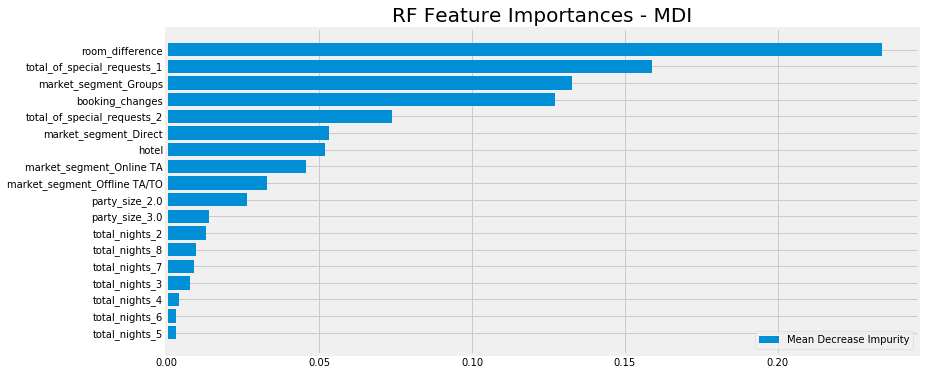

In [6]:
feat_scores = pd.DataFrame({'mdi' : best_rf_model.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='mdi')


fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(feat_scores.index, feat_scores.mdi, label='Mean Decrease Impurity')
ax.set_title('RF Feature Importances - MDI', fontsize=20)
ax.legend()

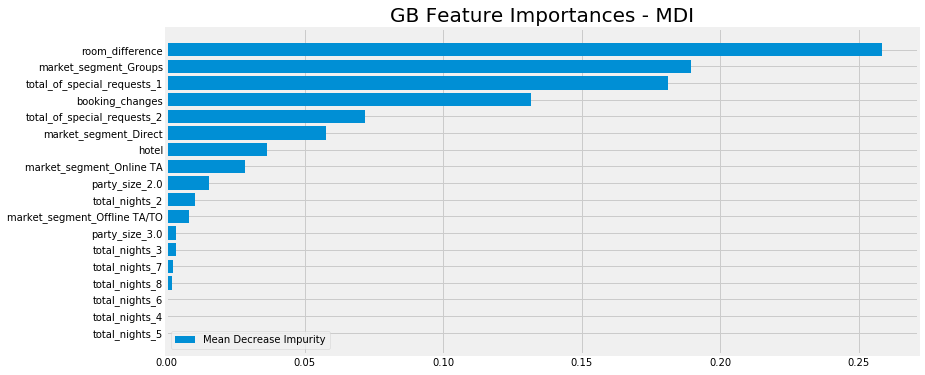

In [7]:
feat_scores = pd.DataFrame({'mdi' : best_gb_model.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='mdi')


fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(feat_scores.index, feat_scores.mdi, label='Mean Decrease Impurity')
ax.set_title('GB Feature Importances - MDI', fontsize=20)
ax.legend()

## Mean Decrease Accuracy

In [8]:
def mda(model, X, y, n_iter=10):
    scores = defaultdict(list)
    cols = X.shape[1]
    
    accuracies = []
    
    splitter = ShuffleSplit(n_iter, test_size=0.3)
    for i, (train_idx, test_idx) in enumerate(splitter.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        acc = accuracy_score(y_test, model.predict(X_test))
        shuffle_scores = []
        for col in range(cols):
            X_train_copy = X_train.copy()
            np.random.shuffle(X_train_copy[:, col])
            X_test_copy = X_test.copy()
            np.random.shuffle(X_test_copy[:, col])

            model.fit(X_train_copy, y_train)

            shuffle_acc = accuracy_score(y_test, model.predict(X_test_copy))
            shuffle_scores.append((acc-shuffle_acc)/acc)
            
        accuracies.append(np.array(shuffle_scores))
        
    return np.mean(np.array(accuracies), axis=0)

In [9]:
rf_mda = mda(best_rf_model, X_train, y_train)

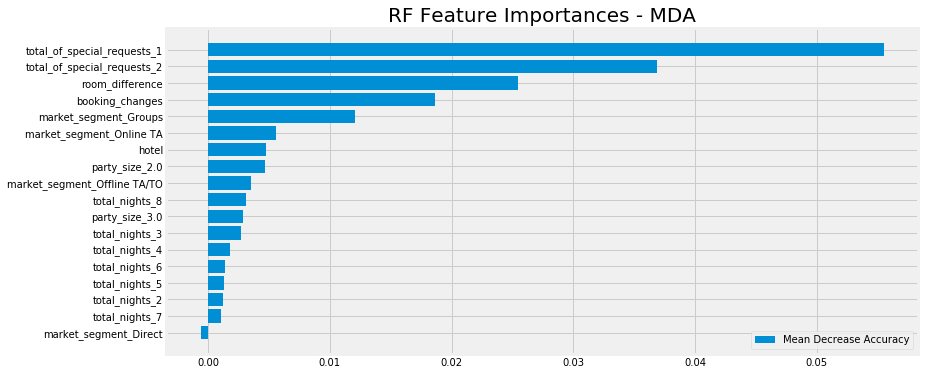

In [10]:
order = np.argsort(rf_mda)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(X.columns[order], rf_mda[order], label='Mean Decrease Accuracy')
ax.set_title('RF Feature Importances - MDA', fontsize=20)
ax.legend()

In [35]:
gb_mda = mda(best_gb_model, X_train, y_train)

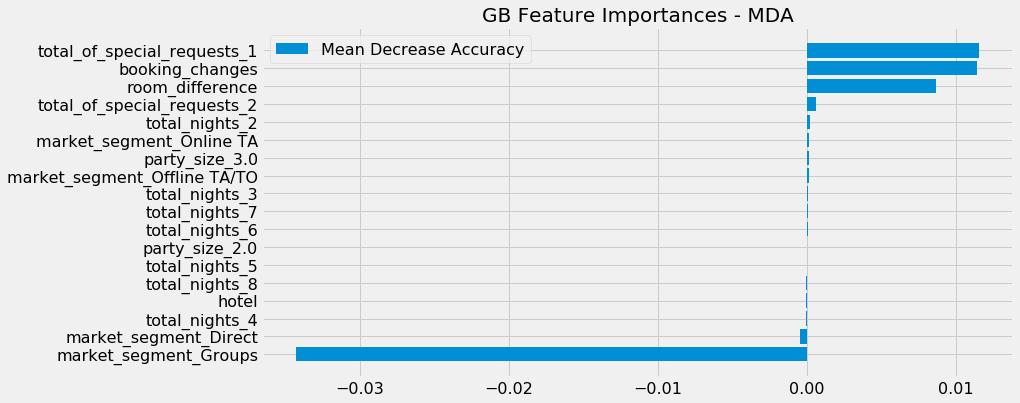

In [36]:
order = np.argsort(gb_mda)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(X.columns[order], gb_mda[order], label='Mean Decrease Accuracy')
ax.set_title('GB Feature Importances - MDA', fontsize=20)
ax.legend()

# Profit Curves

In [9]:
def calc_profit(y_true, y_pred):
    #-------------+--------------+-----------+
    #             | Pred. Cancel | Pred. Not |
    # ------------+--------------+-----------+
    # Act. Cancel |     $153     |   -$153   |
    # ------------+--------------+-----------+
    # Not Fraud   |    -$3366    |    $153   |
    # ------------+--------------+-----------+
    
    # Reasoning:
    # Avg Rate: $102/night
    # Avg. # of Nights: 3
    # Gross Profit: $102 * 3 = $306
    # Expenses take 50% of gross profit
    # Revenue: $153
    
    # Assumptions:
    # If a guest cancels and we predict it, we can guaranteed fill the room (TP)
    # If a guest cancels and we don't predict it, we still have to pay employees (FN)
    # If a guest doesnt cancel and we predict it, they give bad review that 
    #     will affect 10 other potential guests (FP). 10 * $153 = $1530 in lost profit
    # If a guest doesn't cancel and we predict they won't, we make $153 in profit (TN)
    
    
    # calculate confusion matrix
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    
    # hard-coded cost-benefit matrix
    [[cb_tp, cb_fn], [cb_fp, cb_tn]] = np.array([[153, -153], 
                                                 [-1530, 153]])
    
    return np.sum([cb_tp * tp, cb_fn * fn, cb_fp * fp, cb_tn * tn])

def plot_roc_auc(models, X, y, ax, names, cols):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)
    
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_probas = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_probas[:, 1])
        area = auc(fpr, tpr)
        ax.plot(fpr, tpr, label='%s (area = %0.2f)' % (names[i], area), color=cols[i], linewidth=1)
        
    ax.plot([0, 1], [0, 1], linewidth=1, linestyle='--', color='black')
            
            
            
        
def plot_cross_val_profits(models, X, y, ax, names, cols):    
    kf = KFold(n_splits=5, shuffle=True)
    thresholds = np.linspace(0, 1, 101)

    profit_matrix = np.zeros((len(models), 5, len(thresholds)))

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        
        for j, model in enumerate(models):
            model.fit(X_train, y_train)
            y_probas = model.predict_proba(X_test)

            profits = []
            for thresh in thresholds:
                y_pred = (y_probas[:, 1] > thresh) * 1
                profits.append(calc_profit(y_test, y_pred))

            profit_matrix[j, i, :] = np.array(profits)
              
          
        
    avg_profits = np.mean(profit_matrix, axis=1)
    
    
    min_val = np.min(avg_profits)
    max_val = np.max(avg_profits)
    text_height = 1000000
    for i, model in enumerate(models):
        max_thresh = thresholds[np.argmax(avg_profits[i, :])]
        ax.plot(thresholds, avg_profits[i, :], label=names[i], color=cols[i], linewidth=1)
        ax.vlines(max_thresh, min_val, max_val, linestyle='--', color=cols[i], linewidth=1)
        ax.text(0, text_height, 'Threshold: %0.2f, Profit: $%.2f' % (max_thresh, np.max(avg_profits[i, :])), 
                   color=cols[i], fontsize=18)
        text_height -= 400000
    
    #max_thresh = thresholds[np.argmax(avg_profits)]
    
    #ax.plot(thresholds, avg_profits, label='%s' % name, color=col)
    #ax.vlines(max_thresh, -500000, 400000, linestyle='--', color=col)
    #ax.text(0.4, text_height, 'Threshold: %0.2f, Profit: $%0.2f' % (max_thresh, np.max(avg_profits)), 
    #                color=col, fontsize=25)

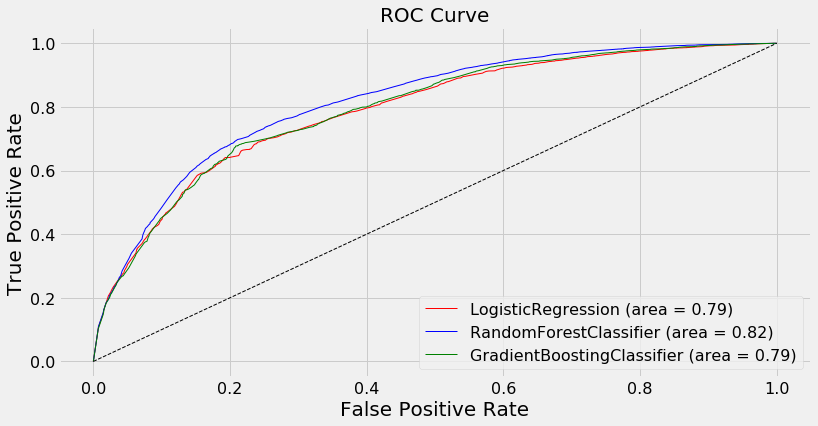

In [39]:
models = [log_reg, best_rf_model, best_gb_model]
names = [m.__class__.__name__ for m in models]
cols = ['r', 'b', 'g']

fig, ax = plt.subplots(figsize=(12, 6))
plot_roc_auc(models, X_train, y_train, ax, names, cols)
ax.set_title('ROC Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.legend()

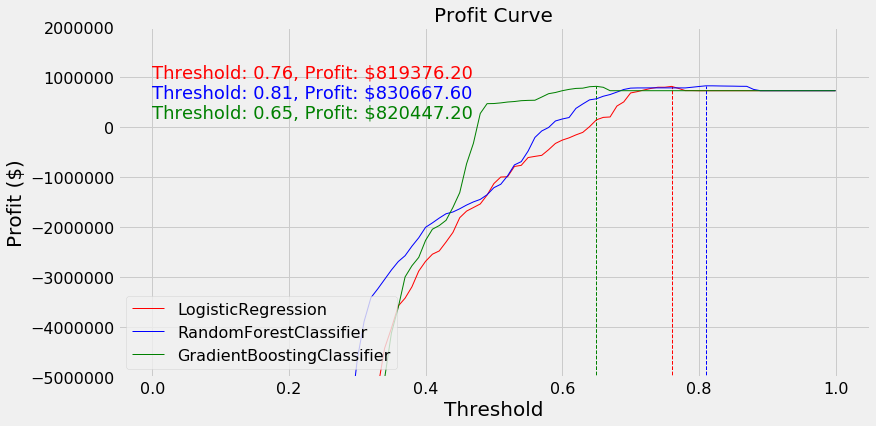

In [38]:
models = [log_reg, best_rf_model, best_gb_model]
names = [m.__class__.__name__ for m in models]
cols = ['r', 'b', 'g']

fig, ax = plt.subplots(figsize=(12, 6))
plot_cross_val_profits(models, X_train, y_train, ax, names, cols)
ax.set_title('Profit Curve', fontsize=20)
ax.set_xlabel('Threshold', fontsize=20)
ax.set_ylabel('Profit ($)', fontsize=20)
ax.set_ylim(-5000000, 2000000)
ax.legend(loc='lower left')

# Using Test Data

In [5]:
data = pd.read_csv('../../data/test/cancellations.csv')

feats = ['hotel','market_segment', 'total_of_special_requests', 
         'total_nights', 'room_difference', 'party_size', 'booking_changes']
dummy_cols = ['total_nights', 'total_of_special_requests', 'market_segment', 'party_size']

X = data[feats].copy()

X.replace(['Resort Hotel', 'City Hotel'], [0, 1], inplace=True)
X.loc[np.argwhere((X['total_nights'] >= 8).values).flatten(), 'total_nights'] = 8
X.loc[np.argwhere((X['total_of_special_requests'] >= 2).values).flatten(), 'total_of_special_requests'] = 2
X.loc[np.argwhere(X['market_segment'].isin(['Aviation', 'Complementary']).values).flatten(), 'market_segment'] = 'Corporate'
X.loc[np.argwhere((X['party_size'] >= 3).values).flatten(), 'party_size'] = 3
X.loc[np.argwhere((X['booking_changes'] >= 1).values).flatten(), 'booking_changes'] = 1

X = pd.get_dummies(X, columns=dummy_cols, drop_first=True)

X_test = X.to_numpy()
y_test = data[['is_canceled']].to_numpy()

In [6]:
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       n_estimators=75)

In [7]:
y_proba = best_rf_model.predict_proba(X_test)

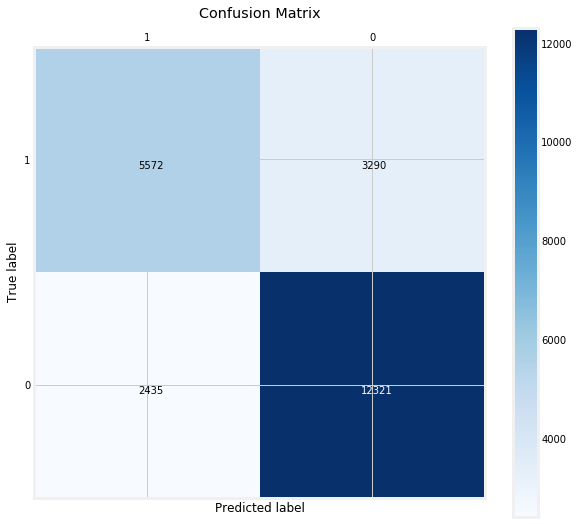

In [14]:

from sklearn.metrics import confusion_matrix

labels = ['1', '0']

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

[[tn, fp], [fn, tp]] = confusion_matrix(y_test, (y_proba[:, 1] > 0.5) * 1)
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
cax = ax.matshow([[tp, fn], [fp, tn]], cmap='Blues')
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.text(-0.04, 0.04, tp, color='black')
plt.text(-0.04, 1.04, fp, color='black')
plt.text(0.95, 0.04, fn, color='black')
plt.text(0.95, 1.04, tn, color='white')
plt.show()


#plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
#plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

In [11]:
calc_profit(y_test, (y_proba[:, 1] > 0.81) * 1)

1032597

In [12]:
X_test.shape

(23618, 18)